In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from transformers import GPT2Model, GPT2Config
import skimage as sk
import random

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

to_numpy = lambda x: x.detach().cpu().numpy()

cuda:1


Files already downloaded and verified


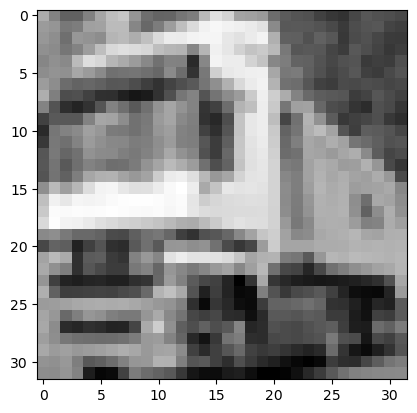

In [ ]:
cifar = torchvision.datasets.CIFAR10(download=True, root='.')
cifar = cifar.data.transpose((0, 3, 1 ,2)).mean(1, keepdims=True)
plt.imshow(cifar[1, 0], cmap='gray')

In [3]:
cifar_small = sk.transform.rescale(cifar, 0.5)
cifar_mini = sk.transform.rescale(cifar, 0.25)

(89400, 1, 16, 16)
(89400, 5)
[1. 0. 0. 0. 0.]


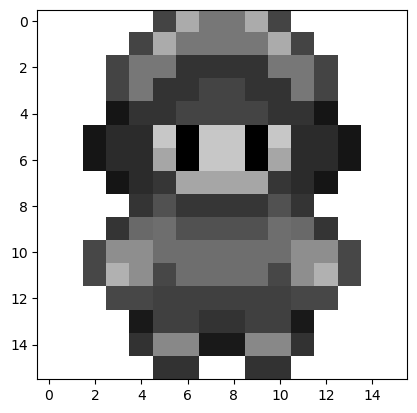

In [4]:
sprites = np.load('sprites.npy')
sprites = np.transpose(sprites, (0, 3, 1, 2)).mean(axis=1, keepdims=True)
sprite_labels = np.load('sprites_labels.npy')
print(sprites.shape)
print(sprite_labels.shape)
plt.imshow(sprites[0, 0], cmap='gray')
print(sprite_labels[0])

In [5]:
class PatchEmbed(nn.Module):
    def __init__(self, image_size=16, patch_size=2, in_chans=1, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.grid_h = image_size // patch_size
        self.grid_w = image_size // patch_size
        self.h_embed = nn.Parameter(torch.randn(1, embed_dim, self.grid_h, 1))
        self.w_embed = nn.Parameter(torch.randn(1, embed_dim, 1, self.grid_w))

    def forward(self, x):
        x = self.proj(x)  # [B, D, H/patch, W/patch]
        x = x + self.h_embed + self.w_embed
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, D]
        return x

class PositionalEmbedding(nn.Module):
    # from https://discuss.pytorch.org/t/transformer-positional-encoding-class/159168
    def __init__(self, max_seq_len, embed_dim):
        """
        Args:
            seq_len: length of input sequence
            embed_model_dim: demension of embedding
        """
        super(PositionalEmbedding, self).__init__()
        self.embed_dim = embed_dim

        pe = torch.zeros(max_seq_len,self.embed_dim)
        for pos in range(max_seq_len):
            for i in range(0,self.embed_dim,2):
                pe[pos, i] = np.sin(pos / (10000 ** ((2 * i)/self.embed_dim)))
                pe[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1))/self.embed_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            x: output
        """
        # make embeddings relatively larger
        x = x * np.sqrt(self.embed_dim)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + torch.as_tensor(self.pe[:, :seq_len]).to(device)
        return x

class SinusoidalPatchEmbed(nn.Module):
    def __init__(self, image_size=16, patch_size=2, in_chans=1, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.embeds = PositionalEmbedding((image_size // patch_size) ** 2, embed_dim)
        
    def forward(self, x):
        x = self.proj(x)  # [B, D, H/patch, W/patch]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, D]
        x = self.embeds(x)
        return x

In [6]:
class SimpleViT(nn.Module):
    def __init__(self, image_size=16, patch_size=2, embed_dim=256, num_layers=4, nhead=4):
        super().__init__()
        self.patch_embed = PatchEmbed(image_size=image_size, embed_dim=embed_dim, patch_size=patch_size)
        encoder = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder, num_layers=num_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        patches = self.patch_embed(x)  # [B*T, P, D]
        # patches = patches.view(B, T, -1, patches.shape[-1])  # [B, T, P, D]
        # patches = patches.flatten(1, 2)  # [B, T*P, D]
        embeddings = self.transformer(patches)[:, -1, :]
        embeddings = embeddings.view(B, T, -1)
        return embeddings

class SimplerViT(nn.Module):
    def __init__(self, image_size=16, patch_size=2, embed_dim=256, output=1, num_layers=1, nhead=1):
        super().__init__()
        self.patch_embed = SinusoidalPatchEmbed(image_size=image_size, embed_dim=embed_dim, patch_size=patch_size)
        encoder = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder, num_layers=num_layers)
        self.out_linear = nn.Linear(embed_dim, output)

    def forward(self, x):
        B, C, H, W = x.shape
        patches = self.patch_embed(x)  # [B*T, P, D]
        # patches = patches.view(B, T, -1, patches.shape[-1])  # [B, T, P, D]
        # patches = patches.flatten(1, 2)  # [B, T*P, D]
        embeddings = self.transformer(patches)[:, -1, :]
        embeddings = embeddings.view(B, -1)
        out = self.out_linear(embeddings)
        return out

class MiniResnet(nn.Module):
    def __init__(self, image_size=16, embed_dim=256, num_layers=8):
        super().__init__()
        self.input_conv = nn.Conv2d(1, 32, 3, 1, 1)
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(nn.Conv2d(32, 32, 3, 1, 1))
        self.output = nn.Linear(image_size**2 *32, embed_dim)
    
    def forward(self, x):
        x = F.relu(self.input_conv(x))
        for layer in self.convs:
            x = F.relu(layer(x)) + x
        x = x.flatten(1)
        x = self.output(x)
        return x


In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, image_size=16, embed_dim=1, num_convs=1, num_channels=1, patch_size=2):
        # Let's just do x convs followed by a single linear layer
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(nn.Conv2d(1, num_channels, kernel_size=patch_size, stride=patch_size, bias=False))
        for i in range(num_convs - 1):
            self.convs.append(nn.Conv2d(num_channels, num_channels, kernel_size=patch_size, padding='same', bias=False))
        self.conv_size = num_channels * (image_size * image_size) // (patch_size * patch_size)
        self.linear = nn.Linear(self.conv_size, embed_dim, bias=False)
        self._initialize_weights()

    def forward(self, x):
        for conv in self.convs:
            x = F.relu(conv(x))
        x = x.flatten(1)
        x = self.linear(x)
        return x
    
    def _initialize_weights(self):
        layers = [m for m in self.modules() if isinstance(m, (nn.Linear, nn.Conv2d))]
        for i, m in enumerate(layers):
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.normal_(m.weight)

class SimpleMLP(nn.Module):
    def __init__(self, image_size=16, embed_dim=1, hidden_dim=100, num_hidden=0):
        super().__init__()
        self.input_size = image_size ** 2
        self.hidden_dim = hidden_dim
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(self.input_size, hidden_dim, bias=False))
        for _ in range(num_hidden):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim, bias=False))
        self.output_layer = nn.Linear(hidden_dim, embed_dim, bias=False)
        self._initialize_weights()
        
    def forward(self, x):
        x = x.flatten(1)
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.output_layer(x)
        
    def _initialize_weights(self):
        layers = [m for m in self.modules() if isinstance(m, (nn.Linear, nn.Conv2d))]
        for i, m in enumerate(layers):
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                if i < len(layers) - 1:
                    nn.init.normal_(m.weight)
                else:
                    nn.init.normal_(m.weight, std=2/self.hidden_dim)
            

In [8]:
class VisionICLTransformer(nn.Module):
    def __init__(self, val_dim=1, embed_dim=256, num_heads=8, num_layers=12, vit_heads=2, vit_layers=8,
                 image_size=16, patch_size=2, max_seq_len=128):
        # max_seq_len corresponds to 2k, so k x_k samples and k f(x_k), and then one more for x_query
        super().__init__()

        self.grid_h = image_size // patch_size
        self.grid_w = image_size // patch_size
        self.num_patches = self.grid_h * self.grid_w

        self.time_embed = nn.Parameter(torch.randn(1, max_seq_len * 2, embed_dim))

        self.val_dim = val_dim
        self.value_proj = nn.Linear(val_dim, embed_dim)

        self.vit = SimpleViT(image_size, patch_size, embed_dim, vit_layers, vit_heads)
        self.cnn = MiniResnet(image_size, embed_dim=embed_dim)
        # decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        # self.transformer = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        config = GPT2Config(
            n_positions=2 * max_seq_len,
            n_embd=embed_dim,
            n_layer=num_layers,
            n_head=num_heads,
            resid_pdrop=0.0,
            embd_pdrop=0.0,
            attn_pdrop=0.0,
            use_cache=False,
        )
        self.transformer = GPT2Model(config)

        self.fc_out = nn.Linear(embed_dim, val_dim)

    def forward(self, images, values):
        B, T, C, H, W = images.shape
        B, T, _ = values.shape
        # images = images.reshape(-1, *images.shape[2:])
        img_embeddings = self.vit(images) #self.cnn(images)
        # img_embeddings = img_embeddings.reshape(B, T, -1)
        # img_embeddings = self.vit(images)

        inds = torch.arange(T).to(device)

        val_embeds = self.value_proj(values)

        embeddings = self.interleave(img_embeddings, val_embeds)
        # embeddings = embeddings + self.time_embed[:, :2 * T]

        # mask = nn.Transformer.generate_square_subsequent_mask(2 * T).to(embeddings.device)
        # memory = torch.zeros(B, 1, embeddings.shape[-1]).to(embeddings.device)
        # x = self.transformer(tgt=embeddings, memory=memory, tgt_mask=mask) 

        # return self.fc_out(x[:, ::2])
        x = self.transformer(inputs_embeds=embeddings).last_hidden_state
        predictions = self.fc_out(x)

        return predictions[:, ::2, 0][:, inds]
    
    def interleave(self, xs, ys):
        B, T, D = xs.shape
        stacked = torch.stack((xs, ys), dim=2)  # [B, T, 2, D]
        interleaved = stacked.view(B, 2 * T, D)
        return interleaved

Actual Toy Problem

In [9]:
def sample_image_set(image_set, b, n, d=None):
    indices = torch.randint(0, image_set.shape[0], (b * n,))
    images = image_set[indices].reshape(b, n, *image_set.shape[1:])
    shape = images.shape
    images = (images - image_set.mean()) / (image_set.std() + 1e-8)
    images = torch.tensor(images).float().to(device)
    # images = images.reshape(b, n, 1, -1)
    if d is not None:
        images[:, :, :, d:] = 0
        images[:, :, :, :, d:] = 0
    # images = images.reshape(shape)
    return images

# def sample_sprites(b, n):
#     indices = torch.randint(0, sprites.shape[0], (b, n))
#     images = torch.tensor(sprites[indices]).float().to(device)
#     return images

# def sample_cifar(b, n, d):
#     indices = torch.randint(0, cifar.shape[0], (b, n))
#     images = torch.tensor(cifar[indices]).float().to(device)
#     images[:, :, :, d:] = 0
#     images[:, :, :, :, d:] = 0
#     return images

def sample_noise(b, n, d, d_max=16):
    noise = torch.randn((b, n, 1, d_max, d_max))
    noise[:, :, :, d:] = 0
    noise[:, :, :, :, d:] = 0
    return noise.to(device)

def ensemble_predict(models, images):
    predictions = []
    for i in range(len(models)):
        predictions.append(models[i](images[i]))
        
    return torch.concat(predictions)

def anneal_lr(optim, lr, update, num_updates, transition_step=1000):
    update -= 1
    if update <= transition_step:
        new_lr = lr * (0.5 ** (update / transition_step))
    else:
        frac = 1 - (update - transition_step) / (num_updates - transition_step)
        new_lr = max(0, 0.5 * lr * frac) # max probably unneccesary but better than having a negative
    optim.param_groups[0]["lr"] = new_lr

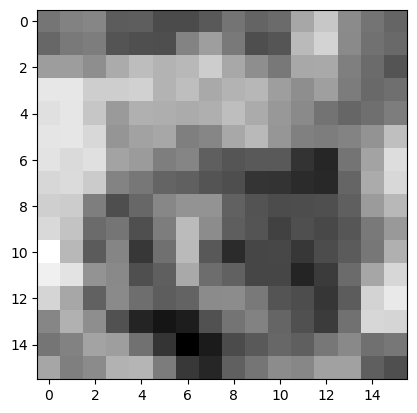

In [10]:
plt.imshow(to_numpy(sample_image_set(cifar_small, 1, 4, 32))[0, 0, 0], cmap='gray')

In [11]:
total_updates = 500000
increase_after = 5000
b = 64
d = 2
k = 8
n = d * k + 1 # might need to lower this back to 64 for colab
e = b
lr = 1e-5
image_size = 8
stop_on = 0.01
current_i = 0
weighting = ((torch.arange(1, n+1) * 2 / n) ** 2).to(device)
print(weighting)

losses = []
final_losses = []
large_transformer = VisionICLTransformer(image_size=image_size, patch_size=4, vit_layers=12).to(device)
optim = torch.optim.AdamW(large_transformer.parameters(), lr)
for i in range(1, total_updates + 1):
    # anneal_lr(optim, lr, i, total_updates, transition_step=20000)
    if i % 100 == 0:
        print(f'epoch: {i}, {np.mean(losses[-10:])}, {np.mean(final_losses[-10:])}, {f_xquery.norm(dim=-1).mean().item()}, {true_f_xquery.norm(dim=-1).mean().item()}')
    if i - current_i == increase_after:
        if d < image_size:
            d += 1
            n = d * k + 1
            increase_after += 0
            current_i = i
            weighting = ((torch.arange(n) * 2 / n) ** 2).to(device)
            print(f'increasing difficulty to d={d}, n={n}')
        elif np.mean(final_losses[-10:]) < stop_on:
            break
    models = [SimplerViT(image_size, patch_size=4, num_layers=1, nhead=1, embed_dim=100).to(device) for _ in range(b)]
    images = sample_image_set(cifar_mini, b, n, d)
    # images = sample_noise(b, n, d, image_size)
    embeddings = ensemble_predict(models, images)
    true_f_xquery= embeddings = embeddings.reshape(b, n, -1)
    f_xquery = large_transformer(images, embeddings)
    true_f_xquery = true_f_xquery.squeeze(-1)
    loss = (weighting * (f_xquery - true_f_xquery) ** 2).sum(1).mean() # * weighting.view(1, -1)
    final_loss = F.mse_loss(f_xquery[:, -1], true_f_xquery[:, -1])
    final_losses.append(final_loss.item())
    losses.append(loss.item())
    optim.zero_grad()
    loss.backward()
    optim.step()

tensor([0.0138, 0.0554, 0.1246, 0.2215, 0.3460, 0.4983, 0.6782, 0.8858, 1.1211,
        1.3841, 1.6747, 1.9931, 2.3391, 2.7128, 3.1142, 3.5433, 4.0000],
       device='cuda:1')


/home/antony/anaconda3/envs/cs182/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch: 100, 1.7589342951774598, 0.0699860367923975, 2.0549378395080566, 2.171894073486328
epoch: 200, 1.5773171544075013, 0.05749103892594576, 1.8870036602020264, 2.2111613750457764
epoch: 300, 1.3776048421859741, 0.053014082834124565, 1.9592781066894531, 2.1937217712402344
epoch: 400, 1.3580537915229798, 0.05479676760733128, 1.913625717163086, 2.1278162002563477
epoch: 500, 1.3945715427398682, 0.053372832015156746, 1.9180859327316284, 2.284543514251709
epoch: 600, 1.2678253889083861, 0.05144645273685455, 1.7482256889343262, 2.0956618785858154
epoch: 700, 1.3092229604721068, 0.05165714100003242, 1.8774054050445557, 2.134307622909546
epoch: 800, 1.255396056175232, 0.0514544453471899, 1.6528382301330566, 1.9926341772079468
epoch: 900, 1.3016992688179017, 0.05061016194522381, 1.54140305519104, 1.8768465518951416
epoch: 1000, 1.226615309715271, 0.045269064418971536, 1.789841890335083, 2.1259536743164062
epoch: 1100, 1.2205989956855774, 0.04785950556397438, 2.104017734527588, 2.400173425674

KeyboardInterrupt: 

In [12]:
torch.save(large_transformer.state_dict(), 'exp4_model.pt')

In [13]:
images = sample_image_set(cifar_mini, b, n, d)
testcnn = SimplerViT(image_size, patch_size=4, num_layers=1, nhead=1, embed_dim=100).to(device)
embeddings = testcnn(images.reshape(b * n, 1, image_size, image_size))
true_f_xquery = embeddings = embeddings.reshape(b, n, -1)
f_xquery = large_transformer(images, embeddings)
true_f_xquery = true_f_xquery.squeeze(-1)
F.mse_loss(f_xquery[:, -1], true_f_xquery[:, -1])
print(f_xquery[:, -1])
print(true_f_xquery[:, -1])

tensor([-0.8322, -1.4516, -0.3246, -1.1772,  1.0677, -1.0896, -0.6940, -0.2682,
        -0.7647, -0.8837, -0.9611, -0.7217, -0.2396, -0.3705, -0.6138,  0.3645,
         0.0901, -0.1792, -1.0239,  0.8116, -1.2630, -0.7903, -0.1313, -0.8368,
        -0.0668, -0.3535,  0.8692,  0.3574,  0.2653,  0.1986, -1.5288, -0.9019,
         0.8322,  0.2304, -0.6968, -1.6698,  0.1312,  0.0883, -0.8676,  0.2070,
        -0.9647, -0.0526, -0.1837, -0.2130, -0.1277,  0.9312, -0.1218, -0.8296,
         0.7736,  0.3540, -0.2570, -1.0162, -0.5155, -1.1425,  0.5652, -1.2778,
         0.4370, -1.0403, -0.2945, -0.3809, -0.0223,  0.0071, -0.7678,  0.1621],
       device='cuda:1', grad_fn=<SelectBackward0>)
tensor([-0.7526, -1.7747, -0.5122, -0.6541,  0.7973, -0.9785, -0.7379, -0.0945,
        -0.5973, -0.8472, -0.8480, -0.8028, -0.3237, -0.4485, -0.4956,  0.2002,
        -0.2168, -0.3946, -1.3417,  1.1720, -1.2088, -0.6516, -0.2849, -1.1435,
        -0.2306, -0.2228,  1.0967, -0.0567, -0.0880, -0.0493, -1.623

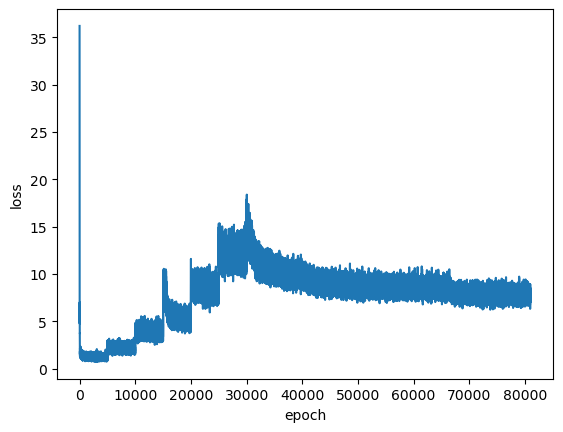

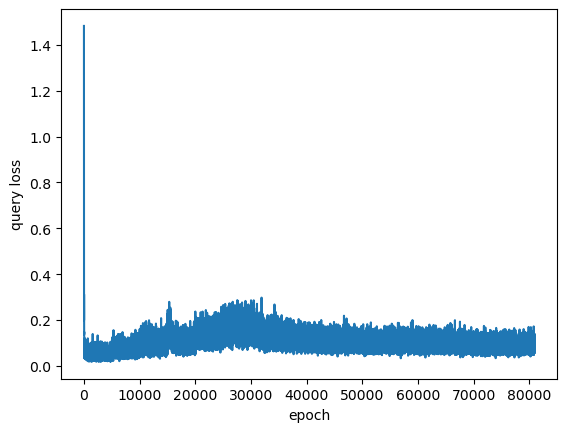

In [14]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('exp4_loss.png')
plt.show()
plt.plot(final_losses)
plt.xlabel('epoch')
plt.ylabel('query loss')
plt.savefig('exp4_query_loss.png')